In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import logistic
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from permutation_weighting.estimator import PW

def create_kang_schafer_data(n, misspecified=False):
    """
    Generate data according to Kang and Schafer (2007) simulation.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool
        Whether to use the misspecified covariates
        
    Returns:
    --------
    dict
        Dictionary containing data and true values
    """
    # Generate true covariates
    X_true = np.random.normal(0, 1, (n, 4))
    
    # Propensity score
    linear_pred = X_true[:, 0] - 0.5 * X_true[:, 1] + 0.25 * X_true[:, 2] + 0.1 * X_true[:, 3]
    prop = logistic.cdf(linear_pred)
    
    # Treatment
    A = np.random.binomial(1, prop, n)
    
    # Outcome (note that treatment effect is 1)
    Y = 210 + A + 27.4 * X_true[:, 0] + 13.7 * X_true[:, 1] + 13.7 * X_true[:, 2] + 13.7 * X_true[:, 3] + np.random.normal(0, 1, n)
    
    # Observed covariates (potentially misspecified)
    if misspecified:
        X = np.column_stack([
            np.exp(X_true[:, 0] / 2),
            X_true[:, 1] * (1 + np.exp(X_true[:, 0])) ** (-1) + 10,
            (X_true[:, 0] * X_true[:, 2] / 25 + 0.6) ** 3,
            (X_true[:, 1] + X_true[:, 3] + 20) ** 2
        ])
    else:
        X = X_true.copy()
    
    # True expected outcomes (since X are standard normal, E[X] = 0)
    true_ey0 = 210
    true_ey1 = 211
    
    return {
        'X': X,
        'A': A,
        'Y': Y,
        'true_ey0': true_ey0,
        'true_ey1': true_ey1,
    }

In [2]:
def compute_weights(data, method):
    """
    Compute weights using various methods.
    
    Parameters:
    -----------
    data : dict
        Data dictionary with X and A
    method : str
        Weighting method to use
        
    Returns:
    --------
    numpy.ndarray
        Weights for each observation
    """
    X = data['X']
    A = data['A']
    n = len(A)
    
    if method == 'Unweighted':
        return np.ones(n)
    
    elif method == 'IPSW (GLM)':
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'IPSW (GBM)':
        model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)  # Avoid extreme weights
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'CBPS':
        # Simplified implementation - in practice you would use the CBPS package
        model = LogisticRegression(solver='lbfgs', max_iter=1000)
        # Include balance constraints by augmenting the loss function
        # (simplified for this implementation)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'SBW':
        # Simplified implementation - in practice you would use the SBW package
        model = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=1000)
        model.fit(X, A)
        ps = model.predict_proba(X)[:, 1]
        ps = np.clip(ps, 0.01, 0.99)
        weights = A / ps + (1 - A) / (1 - ps)
        return weights / np.mean(weights)
    
    elif method == 'PW (GLM)':
        result = PW(A, X, classifier='logit', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (GBM)':
        result = PW(A, X, classifier='boosting', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (SGD)':
        result = PW(A, X, classifier='sgd', num_replicates=100)
        return result['weights']
    
    elif method == 'PW (MLP)':
        result = PW(A, X, classifier='mlp', num_replicates=100)
        return result['weights']
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
def evaluate_potential_outcomes(data, weights):
    """
    Evaluate the estimation of potential outcomes.
    
    Parameters:
    -----------
    data : dict
        Data dictionary
    weights : numpy.ndarray
        Weights for each observation
        
    Returns:
    --------
    dict
        Dictionary with evaluation metrics
    """
    A = data['A']
    Y = data['Y']
    true_ey0 = data['true_ey0']
    true_ey1 = data['true_ey1']
    
    # Normalize weights to sum to n
    n = len(A)
    weights = weights / np.sum(weights) * n
    
    # Estimate expected outcomes
    treated_idx = A == 1
    control_idx = A == 0
    
    est_ey1 = np.sum(Y[treated_idx] * weights[treated_idx]) / np.sum(weights[treated_idx])
    est_ey0 = np.sum(Y[control_idx] * weights[control_idx]) / np.sum(weights[control_idx])
    
    # Compute differences
    diff0 = est_ey0 - true_ey0
    diff1 = est_ey1 - true_ey1
    
    return {
        'est_ey0': est_ey0,
        'est_ey1': est_ey1,
        'diff0': diff0,
        'diff1': diff1
    }

In [3]:
def run_simulation(n_sims=48, sample_sizes=None, methods=None, misspecified=False):
    """
    Run the Kang-Schafer simulation.
    
    Parameters:
    -----------
    n_sims : int
        Number of simulations for each configuration
    sample_sizes : list
        List of sample sizes to evaluate
    methods : list
        List of weighting methods to evaluate
    misspecified : bool
        Whether to use misspecified covariates
        
    Returns:
    --------
    pandas.DataFrame
        Simulation results
    """
    if sample_sizes is None:
        sample_sizes = [100, 250, 500, 1000, 2000, 3500, 5000]
    
    if methods is None:
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'CBPS', 'SBW', 'PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)']
    
    results = []
    
    for n in sample_sizes:
        print(f"Running simulations for n={n}, misspecified={misspecified}")
        
        for sim in range(n_sims):
            if sim % 10 == 0:
                print(f"  Simulation {sim+1}/{n_sims}")
            
            # Generate data
            data = create_kang_schafer_data(n, misspecified)
            
            for method in methods:
                try:
                    # Compute weights
                    weights = compute_weights(data, method)
                    
                    # Evaluate outcomes
                    eval_results = evaluate_potential_outcomes(data, weights)
                    
                    results.append({
                        'sample_size': n,
                        'simulation': sim,
                        'method': method,
                        'diff0': eval_results['diff0'],
                        'diff1': eval_results['diff1'],
                        'est_ey0': eval_results['est_ey0'],
                        'est_ey1': eval_results['est_ey1'],
                        'true_ey0': data['true_ey0'],
                        'true_ey1': data['true_ey1']
                    })
                
                except Exception as e:
                    print(f"Error with method {method} on simulation {sim} with n={n}: {e}")
    
    return pd.DataFrame(results)

def compute_metrics(results):
    """
    Compute metrics from simulation results.
    
    Parameters:
    -----------
    results : pandas.DataFrame
        Simulation results
        
    Returns:
    --------
    pandas.DataFrame
        Computed metrics
    """
    # Group by method and sample size
    grouped = results.groupby(['method', 'sample_size'])
    
    # Compute integrated mean absolute bias and IRMSE
    metrics = grouped.apply(lambda x: pd.Series({
        'bias': np.mean([np.abs(x['diff0']).mean(), np.abs(x['diff1']).mean()]),
        'irmse': np.sqrt(np.mean([np.mean(x['diff0'] ** 2), np.mean(x['diff1'] ** 2)]))
    })).reset_index()
    
    return metrics

def plot_results(metrics, title, save_path=None):
    """
    Plot simulation results.
    
    Parameters:
    -----------
    metrics : pandas.DataFrame
        Computed metrics
    title : str
        Plot title
    save_path : str, optional
        Path to save the plot
    """
    plt.figure(figsize=(15, 6))
    
    # Plot Integrated Mean Absolute Bias
    plt.subplot(1, 2, 1)
    for method in metrics['method'].unique():
        method_data = metrics[metrics['method'] == method]
        plt.plot(method_data['sample_size'], method_data['bias'], marker='o', label=method)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Integrated Mean Absolute Bias')
    plt.title(f'Integrated Mean Absolute Bias - {title}')
    plt.legend()
    plt.grid(True)
    
    # Plot Integrated Root Mean Square Error
    plt.subplot(1, 2, 2)
    for method in metrics['method'].unique():
        method_data = metrics[metrics['method'] == method]
        plt.plot(method_data['sample_size'], method_data['irmse'], marker='o', label=method)
    
    plt.xlabel('Sample Size')
    plt.ylabel('Integrated RMSE')
    plt.title(f'Integrated RMSE - {title}')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

In [6]:
def run_kang_schafer_simulation(test_run=False):
    """
    Run the complete Kang-Schafer simulation.
    
    Parameters:
    -----------
    test_run : bool
        Whether to run a smaller test simulation
    
    Returns:
    --------
    dict
        Simulation results and metrics
    """
    # Configuration
    if test_run:
        n_sims = 3
        sample_sizes = [100, 300, 500,1000, 2000]
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'PW (GLM)', 'PW (SGD)', 'PW (MLP)','PW (GBM)']
        title_suffix = " (Test Run)"
    else:
        n_sims = 48
        sample_sizes = [100, 250, 500, 1000, 2000, 3500, 5000]
        methods = ['Unweighted', 'IPSW (GLM)', 'IPSW (GBM)', 'CBPS', 'SBW', 'PW (GLM)', 'PW (GBM)', 'PW (SGD)', 'PW (MLP)']
        title_suffix = ""
    
    # Well-specified simulation
    print("Running well-specified simulation...")
    start_time = time.time()
    well_specified_results = run_simulation(
        n_sims=n_sims, 
        sample_sizes=sample_sizes, 
        methods=methods, 
        misspecified=False
    )
    well_specified_metrics = compute_metrics(well_specified_results)
    print(f"Well-specified simulation completed in {time.time() - start_time:.2f} seconds")
    
    # Plot well-specified results
    plot_results(
        well_specified_metrics, 
        f"Well-specified{title_suffix}", 
        save_path=f"zz_well_specified_plot{'_test' if test_run else ''}.png"
    )
    
    # Misspecified simulation
    print("Running misspecified simulation...")
    start_time = time.time()
    misspecified_results = run_simulation(
        n_sims=n_sims, 
        sample_sizes=sample_sizes, 
        methods=methods, 
        misspecified=True
    )
    misspecified_metrics = compute_metrics(misspecified_results)
    print(f"Misspecified simulation completed in {time.time() - start_time:.2f} seconds")
    
    # Plot misspecified results
    plot_results(
        misspecified_metrics, 
        f"Misspecified{title_suffix}", 
        save_path=f"zz_misspecified_plot{'_test' if test_run else ''}.png"
    )
    
    return {
        'well_specified_results': well_specified_results,
        'well_specified_metrics': well_specified_metrics,
        'misspecified_results': misspecified_results,
        'misspecified_metrics': misspecified_metrics
    }

Running test simulation...
Running well-specified simulation...
Running simulations for n=100, misspecified=False
  Simulation 1/3
Running simulations for n=300, misspecified=False
  Simulation 1/3
Running simulations for n=500, misspecified=False
  Simulation 1/3
Running simulations for n=1000, misspecified=False
  Simulation 1/3
Running simulations for n=2000, misspecified=False
  Simulation 1/3


/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_72355/1656539507.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = grouped.apply(lambda x: pd.Series({


Well-specified simulation completed in 317.05 seconds


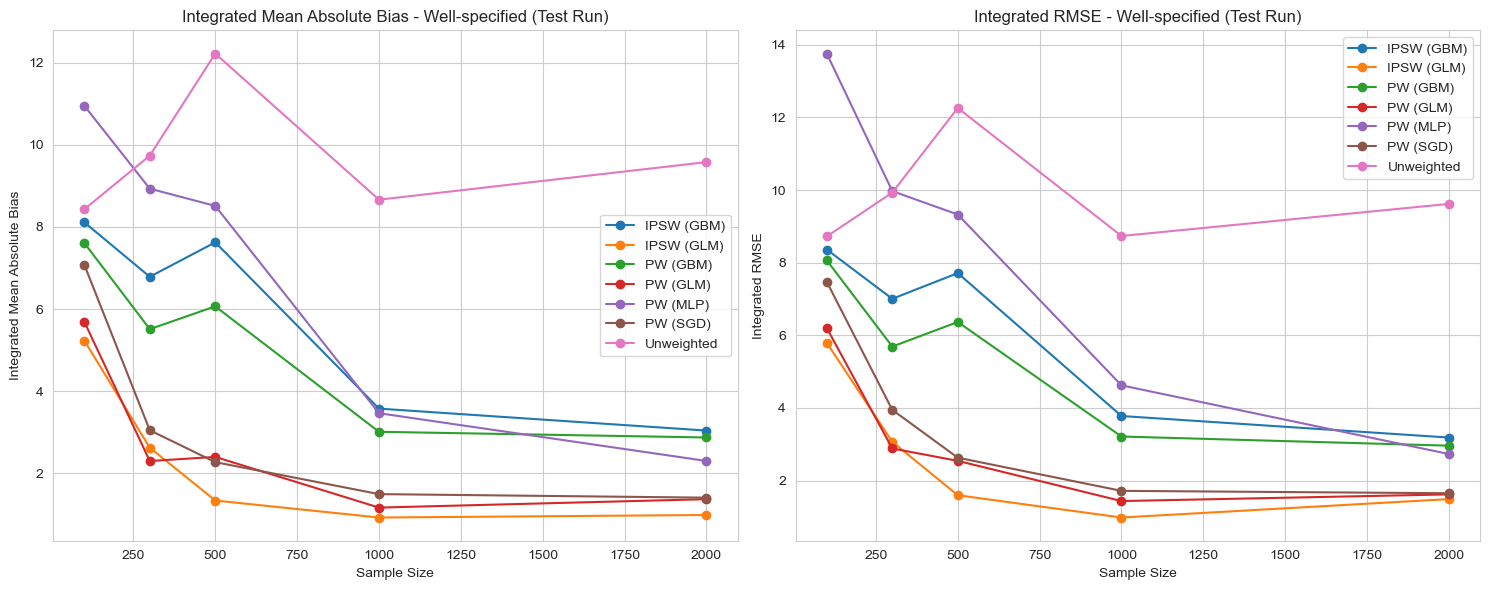

Running misspecified simulation...
Running simulations for n=100, misspecified=True
  Simulation 1/3
Running simulations for n=300, misspecified=True
  Simulation 1/3
Running simulations for n=500, misspecified=True
  Simulation 1/3
Running simulations for n=1000, misspecified=True
  Simulation 1/3
Running simulations for n=2000, misspecified=True
  Simulation 1/3


/var/folders/rl/glk77nxx70v4qglb24jl0byr0000gn/T/ipykernel_72355/1656539507.py:82: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = grouped.apply(lambda x: pd.Series({


Misspecified simulation completed in 514.80 seconds


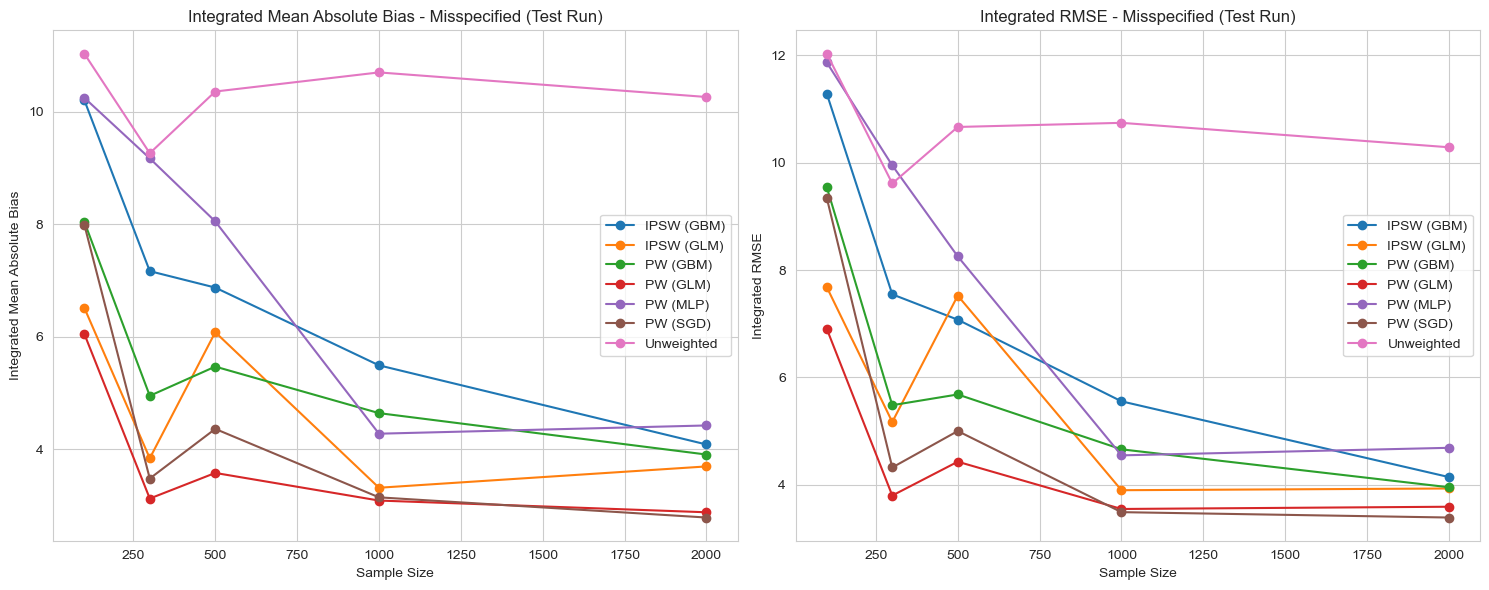

In [7]:
if __name__ == "__main__":
    # Run a test simulation first to make sure everything works
    print("Running test simulation...")
    test_results = run_kang_schafer_simulation(test_run=True)
    
    # # Run the full simulation
    # print("\nRunning full simulation...")
    # full_results = run_kang_schafer_simulation(test_run=False)